In [111]:
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ujson as json
import calendar
import datetime, time
import time as t
import scipy
import numpy as np

#The explode and bbox functions are used to get the bounding box of a geoJSON object
def explode(coords):
    """Explode a GeoJSON geometry's coordinates object and yield coordinate tuples.
    As long as the input is conforming, the type of the geometry doesn't matter."""
    for e in coords:
        if isinstance(e, (float, int, long)):
            yield coords
            break
        else:
            for f in explode(e):
                yield f

def bbox(f):
    x, y = zip(*list(explode(f['geometry']['coordinates'])))
    return np.min(x), np.min(y), np.max(x), np.max(y)

start=t.time()
filename='Cedar_Valley.json'
with open(filename, 'r') as f:
    points = json.load(f)
with open('UtahMajorAquifers.json','r') as f:
    utah=json.load(f)

AquiferShape= {
    'type':'FeatureCollection',
    'features':[]
}
for i in utah['features']:
    if i['properties']['Full_Name']=="Cedar Valley":#Full_Name #AQ_NAME TRINITY
        AquiferShape['features'].append(i) 
lonmin, latmin, lonmax, latmax = bbox(AquiferShape['features'][0])
print lonmin,latmin,lonmax,latmax
lonmin,latmin,lonmax,latmax=round(lonmin*4)/4-.125,round(latmin*4)/4-.125,round(lonmax*4)/4+.125,round(latmax*4)/4+.125
latgrid = np.mgrid[latmin:latmax:.25]
longrid = np.mgrid[lonmin:lonmax:.25]
print latgrid,longrid

-113.21446664569808 37.517879721012775 -112.90497907360974 37.94186918676405
[37.375 37.625 37.875] [-113.375 -113.125]


177
found him


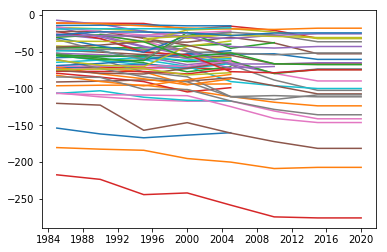

2.79843902588
done


In [112]:
jacknife=373236113111401

















start_date=1985
end_date=2015
interval=5
resolution=.005
time_tolerance=5
min_ratio=.5
min_samples=5
iterations=int((end_date-start_date)/interval+1)
start_time=calendar.timegm(datetime.datetime(start_date, 1, 1).timetuple())
end_time=calendar.timegm(datetime.datetime(end_date, 1, 1).timetuple())
time_u = "Y"
time_v=0
if interval <= .5:
    sixmonths = True
    time_u="M"
    time_v=6
    iterations += 1
    if interval == .25:
        threemonths = True
        iterations += 2
        time_v=3
else:
    time_v=int(interval)
resample_rate=str(time_v)+time_u
print len(points['features'])
start=t.time()
wells_df=pd.DataFrame()
for well in points['features']:
    if well['properties']['HydroID']!=jacknife and well['properties']['HydroID']!=str(jacknife):
        exception=False
        welli=well['properties']['HydroID']
        if 'TsTime' in well:
            if len(well['TsTime'])>=min_samples:
                listlength = len(well['TsTime'])
                length_time = end_time - start_time
                mylength_time = min(well['TsTime'][listlength - 1] - well['TsTime'][0], well['TsTime'][listlength - 1] - start_time, end_time-well['TsTime'][0])
                ratio = abs((float(mylength_time) / length_time))
                if ratio > min_ratio:
                    df = pd.DataFrame(index=pd.to_datetime(well['TsTime'], unit='s', origin='unix'), data=well['TsValue'],\
                                            columns=[welli])
                    df=df[np.logical_not(df.index.duplicated())]
                    try:
                        wells_df=pd.concat([wells_df,df], join="outer", axis=1)
                    except:
                        exception=True
                        print "exception"
                        continue
    else:
        print("found him")
        jacklon=well['geometry']['coordinates'][0]
        jacklat=well['geometry']['coordinates'][1]
wells_df=wells_df.interpolate(method='pchip',limit_area='inside')[str(start_date-1):str(end_date-1)].resample('3M').mean()
wells_df=wells_df.interpolate('nearest',limit=4*time_tolerance,limit_direction='both',fill_value="extrapolate").resample(resample_rate).nearest()
plt.plot(wells_df)
plt.show()
print t.time()-start
print "done"

In [113]:
newinterpolation_df=wells_df
lons=[]
lats=[]
values=[]
elevations=[]
ids=[]
mylon=[]
mylat=[]
myelevs=[]
myids=[]
for wellid in newinterpolation_df.columns:
    for well in points['features']:
        if wellid==str(well['properties']['HydroID']) or wellid==well['properties']['HydroID']:
            mylon.append(well['geometry']['coordinates'][0])
            mylat.append(well['geometry']['coordinates'][1])
            myelevs.append(well['properties']['LandElev'])
            myids.append(str(wellid))
            break
mylon=np.array(mylon)
mylat=np.array(mylat)
myelevs=np.array(myelevs)
myids=np.array(myids)
valueslist=[]
for i in range(iterations):
    myvalue=np.array(newinterpolation_df.iloc[i].tolist())
    valueslist.append(myvalue)
    x=np.isnan(myvalue)
    myelev=np.add(np.array(myelevs),myvalue)
    lons.append(mylon[np.logical_not(x)])
    lats.append(mylat[np.logical_not(x)])
    values.append(myvalue[np.logical_not(x)])
    elevations.append(myelev[np.logical_not(x)])  
    ids.append(myids)
lons = np.array(lons)
lats = np.array(lats)
ids=np.array(ids)
values = np.array(values)
elevations = np.array(elevations)
valueslist=np.array(valueslist)
print lons[0]
print values[0]
print "done"


[-113.1860612 -113.2016172 -113.1691667 -113.1668946 -113.1696724
 -113.1705059 -113.2074512 -113.1632837 -113.1646729 -113.1438391
 -113.1530061 -113.1382839 -113.1096722 -113.1482842 -113.1113389
 -113.1299505 -113.1107834 -113.1505066 -113.1230058 -113.1205059
 -113.103561  -113.1291667 -113.1057834 -113.1293952 -113.1160615
 -113.1113391 -113.092172  -113.0763382 -113.0777272 -113.1107837
 -113.0569444 -113.0999501 -113.0855052 -113.093561  -113.0925
 -113.0368928 -113.1057837 -113.0738385 -113.0318929 -113.0643939
 -113.091111  -113.0691163 -113.0380042 -113.04856   -113.0652273
 -113.1088396 -113.0202262 -113.0952284 -113.0930064 -113.0421716
 -112.9363356 -113.0610617 -112.9383333 -112.9407805 -112.931111
 -113.0496728 -113.0327283]
[ -58.11057718  -96.33853736  -70.79421449  -52.19209713  -47.8433683
  -28.52718084  -46.09703689  -42.25768176  -48.94375917 -153.81967139
  -75.64989406  -53.63462584  -79.31903129  -26.09557062  -91.16909821
  -72.28963113  -51.92222222  -17.0984

In [114]:
# import matplotlib.pyplot as plt

# nlags=6
# #Variogram
# def distance(lon1,lat1,lon2,lat2):
#     d2=(lon2-lon1)**2+(lat2-lat1)**2
#     d=d2**(.5)
#     return d
# def deviation(value1,value2):
#     diff=(value1-value2)**2
#     return diff

# all_distances=[]
# all_deviations=[]
# for step in range(0,len(lons)):
#     distances=[]
#     deviations=[]
#     lon=lons[step]
#     lat=lats[step]
#     value=values[step]
#     elevation=elevations[step]
#     for x in range(0,len(lon)):
#         for y in range(0,len(lon)):
#             if x==y:
#                 continue
#             myx=distance(lon[x],lat[x],lon[y],lat[y])
#             myy=deviation(value[x],value[y])
#             distances.append(myx)
#             deviations.append(myy)
#     distances=np.array(distances)
#     deviations=np.array(deviations)
#     max=np.max(distances)
#     min=np.min(distances)
#     size=((max-min)/4)/nlags

#     xbins=[]
#     ybins=[]
#     meanx=[]
#     meany=[]
    
#     for c in range(0,(nlags*4)):
#         xbin1=[]
#         ybin1=[]
#         for d in range(0,len(distances)):
#             if distances[d]>=(min+size*c) and distances[d]<(min+size*(c+1)):
#                 xbin1.append(distances[d])
#                 ybin1.append(deviations[d])
#         xbin1=np.array(xbin1)
#         ybin1=np.array(ybin1)
#         meanx1=np.average(xbin1)
#         meany1=np.average(ybin1)
#         xbins.append(xbin1)
#         ybins.append(ybin1)
#         meanx.append(meanx1)
#         meany.append(meany1/2)
    
#     plt.figure(figsize=(12, 6))
# #     plt.scatter(distances, deviations, label='Data')
#     plt.scatter(meanx,meany,label='Average')
#     plt.show() 
#     all_distances.append(distances)
#     all_deviations.append(deviations)
# all_distances=np.array(all_distances)
# all_deviations=np.array(all_distances)
            




In [115]:
lonmin=360.0
latmin=90.0
lonmax=-360.0
latmax=-90.0
for i in points['features']:
    if i['geometry']['coordinates'][0]<lonmin:
        lonmin=i['geometry']['coordinates'][0]
    if i['geometry']['coordinates'][0]>lonmax:
        lonmax=i['geometry']['coordinates'][0]
    if i['geometry']['coordinates'][1]<latmin:
        latmin=i['geometry']['coordinates'][1]
    if i['geometry']['coordinates'][1]>latmax:
        latmax=i['geometry']['coordinates'][1]
lonmin=round(lonmin-.05,1)
latmin=round(latmin-.05,1)
lonmax=round(lonmax+.05,1)
latmax=round(latmax+.05,1)
print lonmin,lonmax,latmin,latmax
print len(points['features'])

-113.3 -112.9 37.5 37.9
177


In [116]:
import numpy as np
latgrid = np.mgrid[latmin:latmax:resolution]
longrid = np.mgrid[lonmin:lonmax:resolution]
latrange=len(latgrid)
lonrange=len(longrid)
print latrange, lonrange


80 80


In [117]:
import pygslib
outx=np.repeat(longrid,latrange)
outy=np.tile(latgrid,lonrange)
grids=[]
for i in range(0,iterations):
    params={
        'x':lons[i],
        'y':lats[i],
        'vr':values[i],
        'nx':lonrange,
        'ny':latrange,
        'nz':1,
        'xmn':lonmin,
        'ymn':latmin,
        'zmn':0,
        'xsiz':resolution,
        'ysiz':resolution,
        'zsiz':1,
        'nxdis':1,
        'nydis':1,
        'nzdis':1,
        'outx':outx,
        'outy':outy,
        'radius':2,
        'radius1':2,
        'radius2':2,
        'ndmax':15,
        'ndmin':5,
        'noct':0,
        'ktype':1,
        'idbg':0,
        'c0':0,
        'it':1,
        'cc':500,
        'aa':.2,
        'aa1':.2,
        'aa2':.2
    }
    estimate= pygslib.gslib.kt3d(params)
    print i
    array=estimate[0]['outidpower']#outest
    array2=estimate[0]['outidpower']
    grid=np.reshape(array,(lonrange,latrange))
    grid2=np.reshape(array2,(lonrange,latrange))
    x=np.isnan(grid)
    grid[x]=grid2[x]
    grids.append(grid)
grids=np.array(grids)

0
1
2
3
4
5
6


In [118]:
with open('UtahMajorAquifers.json','r') as f:
    allwells = ''
    wells = f.readlines()
    for i in range(0, len(wells)):
        allwells += wells[i]
utah=json.loads(allwells)


AquiferShape= {
    'type':'FeatureCollection',
    'features':[]
}
print utah['features'][0].viewkeys()
for i in utah['features']:
    if i['properties']['Full_Name']=="Cedar Valley":#Full_Name #AQ_NAME TRINITY
        AquiferShape['features'].append(i)

with open('shapefile.json','w') as outfile:
    json.dump(AquiferShape, outfile)
    

dict_keys([u'geometry', u'type', u'properties'])


In [119]:
from __future__ import division
import netCDF4
from netCDF4 import Dataset
import numpy as np
import os
import time as t
from scipy import interpolate
from sklearn.utils import resample
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import numpy as np
import matplotlib.pyplot as plt
import cython
volunit="Acre-ft"

interpolation_type="Kriging"

latlen=len(latgrid)
lonlen=len(longrid)
filename='testinterpolate2.nc'
h=netCDF4.Dataset(filename,'w',format="NETCDF4")
h.interpolation="Kriging Pandas Interpolation"
h.start_date=start_date
h.end_date=end_date
h.interval=interval
h.resolution=resolution
h.min_samples=min_samples
h.min_ratio=min_ratio
h.time_tolerance=time_tolerance
h.default=0
h.units='English'


time = h.createDimension("time", 0)
lat = h.createDimension("lat", latlen)
lon = h.createDimension("lon", lonlen)
hydroid=h.createDimension("hydroid", len(ids[0]))
latitude=h.createVariable("lat",np.float64,("lat"))
longitude=h.createVariable("lon",np.float64,("lon"))
time=h.createVariable("time",np.float64,("time"), fill_value="NaN")
hydroids=h.createVariable("hydroid",str,("hydroid"), fill_value="NaN")
hydroids.axis="H"

tsvalue=h.createVariable("tsvalue",np.float64,('time','hydroid'),fill_value=-9999)
tsvalue.units="ft"
tsvalue.coordinates="time hydroid"

depth=h.createVariable("depth",np.float64,('time','lon','lat'),fill_value=-999)
depth.long_name="Depth to Groundwater"
depth.units="ft"
depth.grid_mapping="WGS84"
depth.cell_measures="area: area"
depth.coordinates="time lat lon"

elevation=h.createVariable("elevation",np.float64,('time','lon','lat'),fill_value=-999)
elevation.long_name="Elevation of Groundwater"
elevation.units="ft"
elevation.grid_mapping="WGS84"
elevation.cell_measures="area: area"
elevation.coordinates="time lat lon"

drawdown=h.createVariable("drawdown",np.float64,('time','lon','lat'),fill_value=-999)
drawdown.long_name="Well Drawdown"
drawdown.units="ft"
drawdown.grid_mapping="WGS84"
drawdown.cell_measures="area: area"
drawdown.coordinates="time lat lon"

volume = h.createVariable("volume", np.float64, ('time', 'lon', 'lat'), fill_value=-9999)
volume.long_name = "Change in aquifer storage volume since " + str(start_date)
volume.units = volunit
volume.grid_mapping = "WGS84"
volume.cell_measures = "area: area"
volume.coordinates = "time lat lon"

latitude.long_name="Latitude"
latitude.units="degrees_north"
latitude.axis="Y"
longitude.long_name="Longitude"
longitude.units="degrees_east"
longitude.axis="X"
time.axis="T"
time.units='days since 0001-01-01 00:00:00 UTC'
latitude[:]=latgrid[:]
longitude[:]=longrid[:]  
hydroids[:]=ids[0,:]
year=start_date
timearray=[]#[datetime.datetime(2000,1,1).toordinal()-1,datetime.datetime(2002,1,1).toordinal()-1]
            
for i in range(0,iterations):
    print i
    timearray.append(datetime.datetime(year, 1, 1).toordinal() - 1)
    year += interval
    time[i] = timearray[i]
    tsvalue[i,:]=valueslist[i,:]
    for x in range(0,lonrange):
            depth[i,x,:]=grids[i,x,:]
            elevation[i,x,:]=grids[i,x,:]
            if i==0:
                drawdown[i,x,:]=0
            else:
                drawdown[i,x,:]=depth[i,x,:]-depth[0,x,:]

h.close()
os.system("./aquifersubset.sh %s" % (filename))
# serverpath="/home/student/tds/apache-tomcat-8.5.30/content/thredds/public/testdata/groundwater"
# destination= os.path.join(serverpath, filename)
# os.rename(filename, destination)
end=t.time()
print(end-start)



0
1
2
3
4
5
6
9.6287920475


In [120]:
# os.system("./aquifersubset.sh %s" % (filename))

In [121]:
import urllib
import copy
from xml.etree import cElementTree as ET
# This function returns the first and last available time from a url of a getcapabilities page located on a Thredds Server
def getTimeBounds(url):
    f=urllib.urlopen(url)
    tree=ET.parse(f)
    root=tree.getroot()
    #These lines of code find the time dimension information for the netcdf on the Thredds server
    dim=root.findall('.//{http://www.opengis.net/wms}Dimension')
    dim=dim[0].text
    times=dim.split(',')
    times.pop(0)
    timemin=times[0]
    timemax=times[-1]
    #timemin and timemax are the first and last available times on the specified url
    return timemin,timemax
#This function returns a pandas dataframe of the timeseries values of a specific layer 
#at a specific latitude and longitude from a file on a Thredds server
#server: the url of the netcdf desired netcdf file on the Thredds server to read
#layer: the name of the layer to extract timeseries information from for the netcdf file
#lat: the latitude of the point at which to extract the timeseries
#lon: the longitude of the point at which to extract the timeseries
#returns df: a pandas dataframe of the timeseries at lat and lon for the layer in the server netcdf file
def getThreddsValue(server,layer,lat,lon):
    #calls the getTimeBounds function to get the first and last available times for the netcdf file on the server
    timemin,timemax=getTimeBounds(server+"?service=WMS&version=1.3.0&request=GetCapabilities")
    #These lines properly format a url request for the timeseries of a speific layer from a netcdf on 
    #a Thredds server
    server=server+"?service=WMS&version=1.3.0&request=GetFeatureInfo&CRS=CRS:84&QUERY_LAYERS="+layer
    server=server+"&X=0&Y=0&I=0&J=0&BBOX="+str(lon)+','+str(lat)+','+str(lon+.001)+','+str(lat+.001)
    server=server+"&WIDTH=1&Height=1&INFO_FORMAT=text/xml"
    server=server+'&TIME='+timemin+'/'+timemax
    f = urllib.urlopen(server)
    tree=ET.parse(f)
    root=tree.getroot()
    features=root.findall('FeatureInfo')
    times=[]
    values=[]
    for child in features:
        time=datetime.datetime.strptime(child[0].text,"%Y-%m-%dT%H:%M:%S.%fZ")
        times.append(time)
        values.append(child[1].text)
    
    df=pd.DataFrame(index=times, columns=[layer],data=values)
    df[layer]=df[layer].replace('none',np.nan).astype(float)
    return df

#function to convert a datetime object to milliseconds since epoch
def datetime_to_float(d):
    epoch = datetime.datetime.utcfromtimestamp(0)
    total_seconds =  (d - epoch).total_seconds()
    # total_seconds will be in decimals (millisecond precision)
    return total_seconds


server="http://localhost:8080/thredds/wms/testAll/groundwater/testinterpolate2.nc"
layer="depth"
#calls a function to return a df of the timeseries of the pdsi at 37.7,-113
df1=getThreddsValue(server,layer,jacklat,jacklon)
print(df1)
print(jacklat,jacklon)
print(jacknife)


                depth
1989-12-30 -59.906696
1994-12-30 -59.093826
1999-12-30 -59.146750
2004-12-30 -59.335690
2009-12-30 -59.376880
2014-12-30 -66.834030
(37.543312, -113.1891168)
373236113111401
